In [1]:
import pandas as pd
import json
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, classification_report, auc
import numpy as np

/Users/hamza/Code/CS5914/project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getcwd()

'/Users/hamza/Code/CS5914/project/analysis'

# Similarity Score Utils

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_similarity(output, ground):
    # Embed
    emb_ground = model.encode(ground, convert_to_tensor=True)
    emb_completion = model.encode(output, convert_to_tensor=True)

    # Cosine similarity
    score = util.cos_sim(emb_ground, emb_completion).item()

    return score

In [4]:
def add_similarity_scores(df):
    similarities = []
    
    for idx, row in df.iterrows():
        completion = row['completion']
        ground = row['ground']
        
        similarity = compute_similarity(completion, ground)
        similarities.append(similarity)

    df['similarity'] = similarities
    return df

In [33]:
def word_accuracy(pred, true):
    """
    Compute token‑level accuracy for a single prediction/ground pair.
    Returns the fraction of tokens in `true` that exactly match
    the corresponding tokens in `pred`.
    """
    true_tokens = true.split()
    if not true_tokens:
        return 0.0
    pred_tokens = pred.split()
    # compare up to the length of the ground truth
    matches = sum(1 for p, t in zip(pred_tokens, true_tokens) if p == t)
    return matches / len(true_tokens)

def add_word_accuracy(df):
    accuracies = []
    
    for idx, row in df.iterrows():
        completion = row['completion']
        ground = row['ground']
        
        accuracy = word_accuracy(completion, ground)
        accuracies.append(accuracy)

    df['accuracy'] = accuracies
    return df

# Papers & Masking

## Read Data

In [5]:
PAPERS_CONTEXTLENGTH_FILES = [
    '../completions/masked-papers-completions-temperature-0.1.jsonl',
    '../completions/masked-papers-completions-temperature-0.5.jsonl'
]

In [6]:
papers_completions = []
for file in PAPERS_CONTEXTLENGTH_FILES:
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            papers_completions.append(json.loads(line))

In [7]:
papers_completions = pd.DataFrame(papers_completions)
papers_completions.head()

,id,title,authors,abstract,published,type,mask_prob,context_length,input,ground,completion,temperature,prompt
0,1709.01507,Squeeze-and-Excitation Networks,"[Jie Hu, Li Shen, Samuel Albanie, Gang Sun, En...",The central building block of convolutional ne...,2017-09-05T17:42:13+00:00,before,0.25,1024,match those sug- gested <MASK> the original <M...,match those sug- gested by the original papers...,match those suggested to the original. We repo...,0.1,You are a factual information retrieval assist...
1,1801.04381,MobileNetV2: Inverted Residuals and Linear Bot...,"[Mark Sandler, Andrew Howard, Menglong Zhu, An...",In this paper we describe a new mobile archite...,2018-01-13T04:46:26+00:00,before,0.25,1024,"[33]. <MASK> MobileNetV2, the ﬁrst layer <MASK...","[33]. For MobileNetV2, the ﬁrst layer of SSDLi...","[33]. In MobileNetV2, the first layer of SSDLi...",0.1,You are a factual information retrieval assist...
2,1708.02002,Focal Loss for Dense Object Detection,"[Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kai...",The highest accuracy object detectors to date ...,2017-08-07T06:32:42+00:00,before,0.25,1024,select the two <MASK> <MASK> <MASK> 1a and 1b)...,select the two together (see Tables 1a and 1b)...,select the two best performing models (Figure ...,0.1,You are a factual information retrieval assist...
3,1707.01083,ShuffleNet: An Extremely Efficient Convolution...,"[Xiangyu Zhang, Xinyu Zhou, Mengxiao Lin, Jian...",We introduce an extremely computation-efficien...,2017-07-04T17:42:58+00:00,before,0.25,1024,<MASK> <MASK> <MASK> evaluations <MASK> <MASK>...,channel shufﬂe. The evaluations are performed ...,Channel shuffle evaluations are conducted unde...,0.1,You are a factual information retrieval assist...
4,1803.01534,Path Aggregation Network for Instance Segmenta...,"[Shu Liu, Lu Qi, Haifang Qin, Jianping Shi, Ji...",The way that information propagates in neural ...,2018-03-05T07:46:36+00:00,before,0.25,1024,- / (cid:88) (cid:88) (cid:88) (cid:88) (cid:8...,- / (cid:88) (cid:88) (cid:88) (cid:88) (cid:8...,- / (cid:88) (cid:88) (cid:88) (cid:88) (cid:8...,0.1,You are a factual information retrieval assist...


## Compute Similarities

In [8]:
papers_completions = add_similarity_scores(papers_completions)

## Analysis

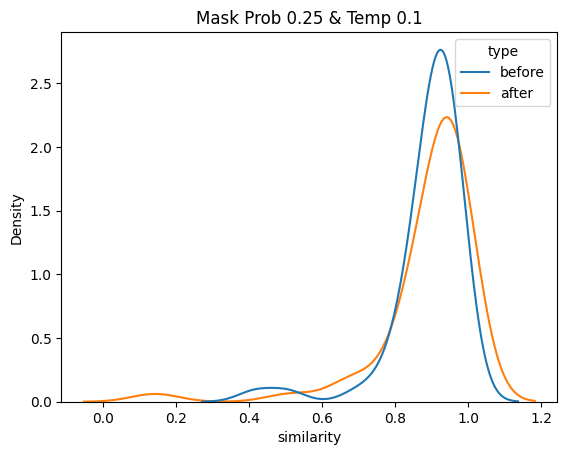

In [9]:
d = papers_completions[(papers_completions['mask_prob'] == 0.25) & (papers_completions['temperature'] == 0.1)]
sns.kdeplot(data=d, x="similarity", hue='type')
plt.title('Mask Prob 0.25 & Temp 0.1')
plt.show()

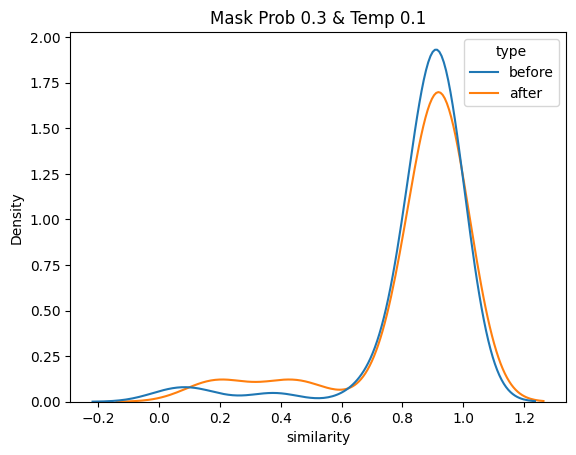

In [10]:
d = papers_completions[(papers_completions['mask_prob'] == 0.3) & (papers_completions['temperature'] == 0.1)]
sns.kdeplot(data=d, x="similarity", hue='type')
plt.title('Mask Prob 0.3 & Temp 0.1')
plt.show()

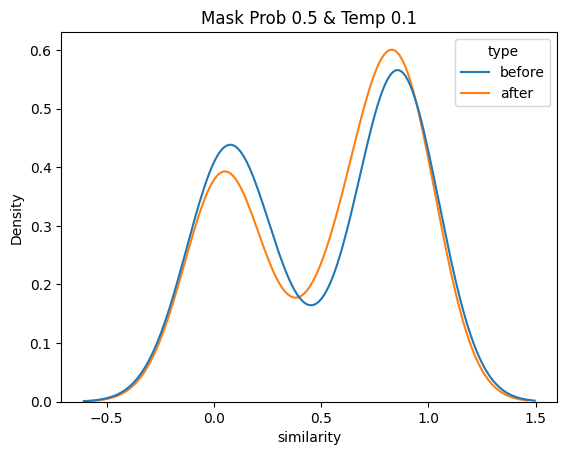

In [11]:
d = papers_completions[(papers_completions['mask_prob'] == 0.5) & (papers_completions['temperature'] == 0.1)]
sns.kdeplot(data=d, x="similarity", hue='type')
plt.title('Mask Prob 0.5 & Temp 0.1')
plt.show()

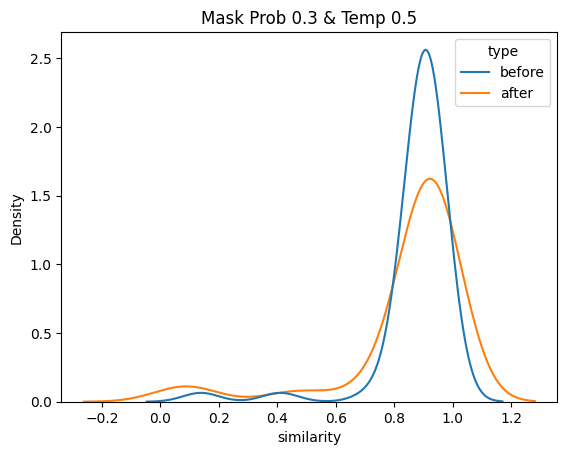

In [12]:
d = papers_completions[(papers_completions['mask_prob'] == 0.3) & (papers_completions['temperature'] == 0.5)]
sns.kdeplot(data=d, x="similarity", hue='type')
plt.title('Mask Prob 0.3 & Temp 0.5')
plt.show()

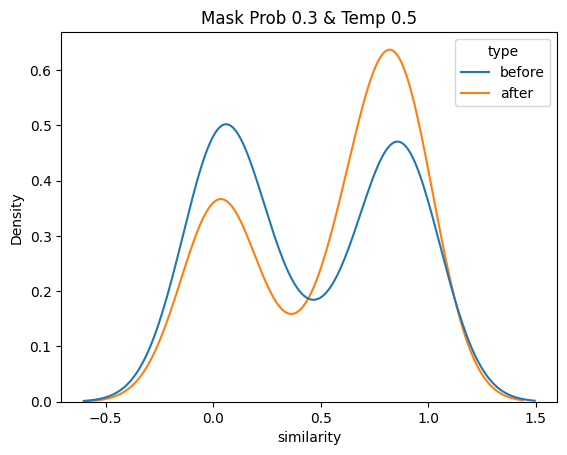

In [15]:
d = papers_completions[(papers_completions['mask_prob'] == 0.5) & (papers_completions['temperature'] == 0.5)]
sns.kdeplot(data=d, x="similarity", hue='type')
plt.title('Mask Prob 0.3 & Temp 0.5')
plt.show()

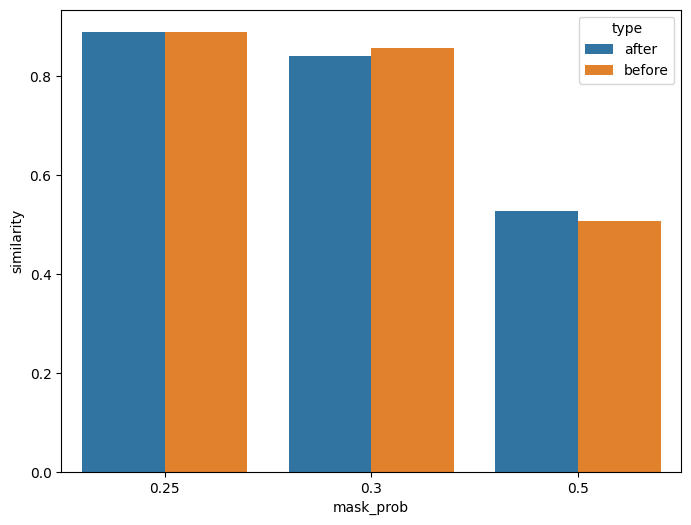

In [13]:
d = papers_completions[(papers_completions['temperature'] == 0.1)]
plt.figure(figsize=(8, 6))
x = d.groupby(['type', 'mask_prob']).mean('similarity').reset_index()
sns.barplot(x, x='mask_prob', y='similarity', hue='type')
plt.show()

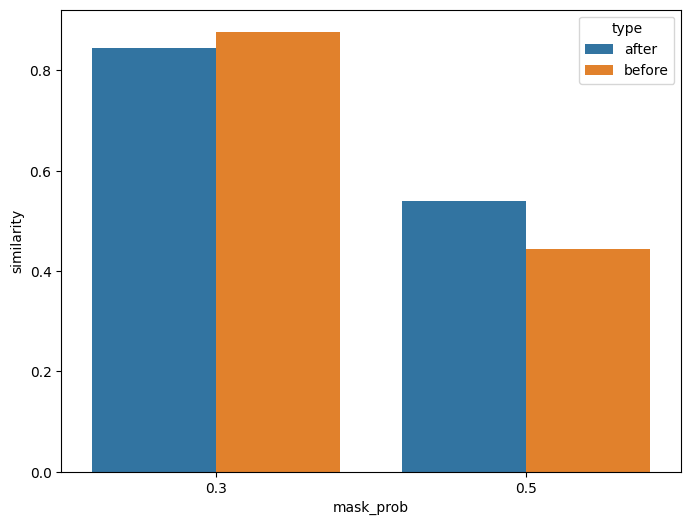

In [14]:
d = papers_completions[(papers_completions['temperature'] == 0.5)]
plt.figure(figsize=(8, 6))
x = d.groupby(['type', 'mask_prob']).mean('similarity').reset_index()
sns.barplot(x, x='mask_prob', y='similarity', hue='type')
plt.show()

# Abstract & Masking

In [85]:
PAPERS_FILES = [
    '../completions/masked-abstract-papers-completions-temperature-0.1.jsonl',
]

In [86]:
papers_completions = []
for file in PAPERS_FILES:
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            papers_completions.append(json.loads(line))

In [87]:
papers_completions = pd.DataFrame(papers_completions)
papers_completions.head()

,id,title,authors,published,type,mask_prob,context_length,input,ground,completion,temperature,prompt
0,1709.01507,Squeeze-and-Excitation Networks,"[Jie Hu, Li Shen, Samuel Albanie, Gang Sun, En...",2017-09-05T17:42:13+00:00,before,0.3,184,<MASK> central building block of convolutional...,The central building block of convolutional ne...,The central building block of convolutional ne...,0.1,You are a factual information retrieval assist...
1,1801.04381,MobileNetV2: Inverted Residuals and Linear Bot...,"[Mark Sandler, Andrew Howard, Menglong Zhu, An...",2018-01-13T04:46:26+00:00,before,0.3,218,In <MASK> paper <MASK> describe a new mobile a...,In this paper we describe a new mobile archite...,"In this paper, we describe a new mobile archit...",0.1,You are a factual information retrieval assist...
2,1708.02002,Focal Loss for Dense Object Detection,"[Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kai...",2017-08-07T06:32:42+00:00,before,0.3,195,The highest accuracy object detectors to date ...,The highest accuracy object detectors to date ...,The highest accuracy object detectors to date ...,0.1,You are a factual information retrieval assist...
3,1707.01083,ShuffleNet: An Extremely Efficient Convolution...,"[Xiangyu Zhang, Xinyu Zhou, Mengxiao Lin, Jian...",2017-07-04T17:42:58+00:00,before,0.3,99,We introduce <MASK> extremely <MASK> CNN <MASK...,We introduce an extremely computation-efficien...,We introduce an extremely efficient CNN archit...,0.1,You are a factual information retrieval assist...
4,1803.01534,Path Aggregation Network for Instance Segmenta...,"[Shu Liu, Lu Qi, Haifang Qin, Jianping Shi, Ji...",2018-03-05T07:46:36+00:00,before,0.3,152,<MASK> way <MASK> information <MASK> in neural...,The way that information propagates in neural ...,The efficient way of processing information fl...,0.1,You are a factual information retrieval assist...


## Compute Similarities

In [88]:
papers_completions = add_similarity_scores(papers_completions)

## Compute Accuracies

In [89]:
papers_completions = add_word_accuracy(papers_completions)

## Analysis

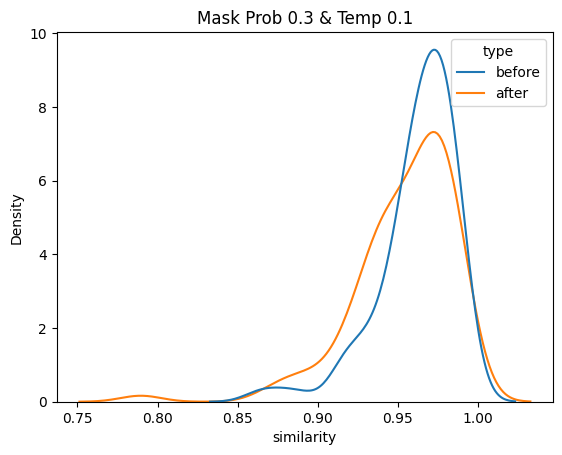

In [90]:
d = papers_completions[(papers_completions['mask_prob'] == 0.3) & (papers_completions['temperature'] == 0.1)]
sns.kdeplot(data=d, x="similarity", hue='type')
plt.title('Mask Prob 0.3 & Temp 0.1')
plt.show()

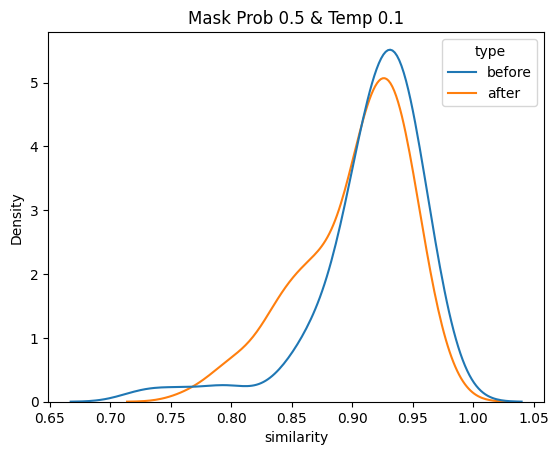

In [91]:
d = papers_completions[(papers_completions['mask_prob'] == 0.5) & (papers_completions['temperature'] == 0.1)]
sns.kdeplot(data=d, x="similarity", hue='type')
plt.title('Mask Prob 0.5 & Temp 0.1')
plt.show()

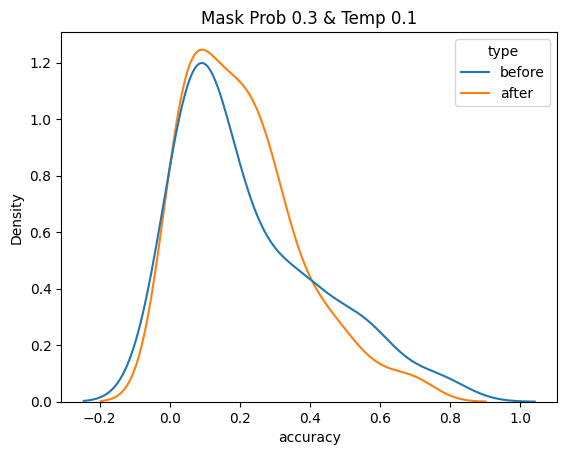

In [92]:
d = papers_completions[(papers_completions['mask_prob'] == 0.3) & (papers_completions['temperature'] == 0.1)]
sns.kdeplot(data=d, x="accuracy", hue='type')
plt.title('Mask Prob 0.3 & Temp 0.1')
plt.show()

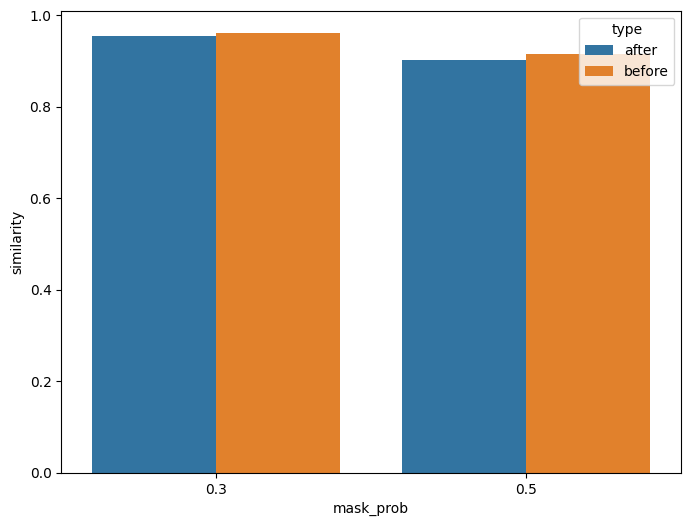

In [93]:
d = papers_completions[(papers_completions['temperature'] == 0.1)]
plt.figure(figsize=(8, 6))
x = d.groupby(['type', 'mask_prob']).mean('similarity').reset_index()
sns.barplot(x, x='mask_prob', y='similarity', hue='type')
plt.show()

# News & Masking

In [5]:
NEWS_FILES = [
    '../completions/masked-news-completions-temperature-0.1-4o.jsonl',
]

In [6]:
news_completions = []
for file in NEWS_FILES:
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            news_completions.append(json.loads(line))

In [7]:
news_completions = pd.DataFrame(news_completions)
news_completions.head()

,title,date,url,type,mask_prob,context_length,input,ground,completion,temperature,prompt
0,King Charles to receive new sword at Scottish ...,20230630,https://www.bbc.com/news/uk-scotland-glasgow-w...,before,0.4,1024,A <MASK> sword will <MASK> presented to King C...,A new sword will be presented to King Charles ...,A new sword will be presented to King Charles ...,0.1,You are a factual information retrieval assist...
1,Florida murder suspect arrested after 40 years,20230630,https://www.bbc.com/news/world-us-canada-66073441,before,0.4,1024,A <MASK> murder <MASK> <MASK> <MASK> <MASK> on...,A Florida murder suspect who featured thrice o...,A suspected murder suspect was captured on Ame...,0.1,You are a factual information retrieval assist...
2,The white roofs cooling women's homes in India...,20230628,https://www.bbc.com/future/article/20230628-th...,before,0.4,1024,<MASK> <MASK> <MASK> <MASK> <MASK> <MASK> impa...,Extreme heat is having a detrimental impact on...,Extreme heat has a significant impact on peopl...,0.1,You are a factual information retrieval assist...
3,Australia legalises psychedelics for mental he...,20230630,https://www.bbc.com/news/world-australia-66072427,before,0.4,1024,Australia <MASK> become the <MASK> country <MA...,Australia has become the first country in the ...,Australia has become the first country in the ...,0.1,You are a factual information retrieval assist...
4,Chinese spy balloon did not collect informatio...,20230629,https://www.bbc.com/news/world-us-canada-66062562,before,0.4,1024,The Chinese balloon that crossed <MASK> contin...,The Chinese balloon that crossed the continent...,The Chinese balloon that crossed the continent...,0.1,You are a factual information retrieval assist...


In [8]:
news_completions = add_similarity_scores(news_completions)

In [9]:
news_completions['type'] = news_completions['type'].map({'before': 'member', 'after': 'non-member'})

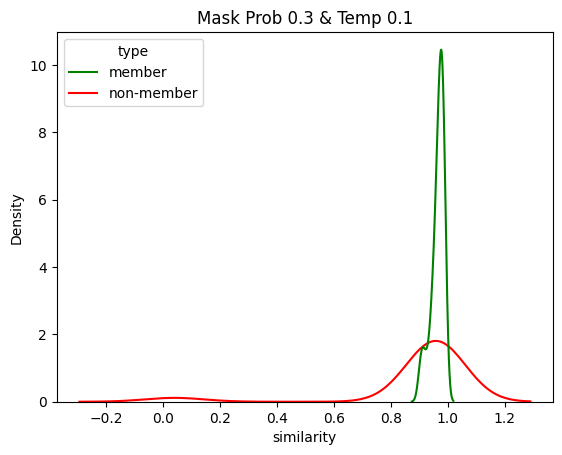

In [14]:
MASK_PROB = 0.3
TEMP = 0.1

d = news_completions[(news_completions['mask_prob'] == MASK_PROB) & (news_completions['temperature'] == TEMP)]
sns.kdeplot(data=d, x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Mask Prob {MASK_PROB} & Temp {TEMP}')
plt.show()

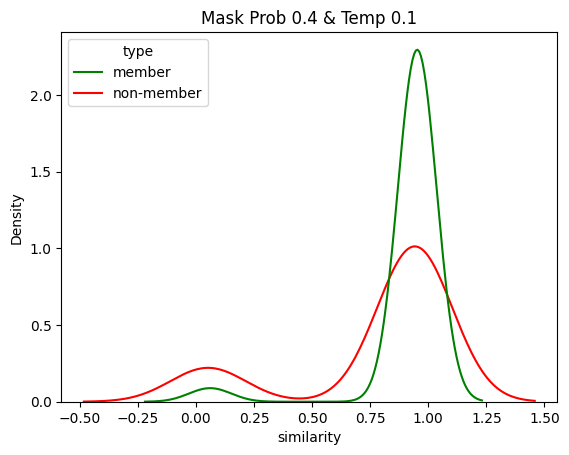

In [15]:
MASK_PROB = 0.4
TEMP = 0.1

d = news_completions[(news_completions['mask_prob'] == MASK_PROB) & (news_completions['temperature'] == TEMP)]
sns.kdeplot(data=d, x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Mask Prob {MASK_PROB} & Temp {TEMP}')
plt.show()

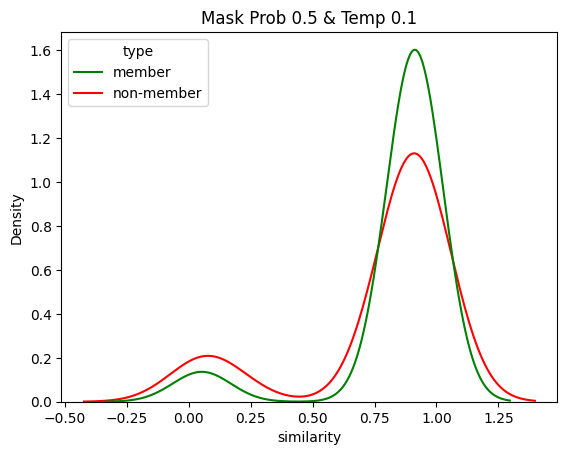

In [16]:
MASK_PROB = 0.5
TEMP = 0.1

d = news_completions[(news_completions['mask_prob'] == MASK_PROB) & (news_completions['temperature'] == TEMP)]
sns.kdeplot(data=d, x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Mask Prob {MASK_PROB} & Temp {TEMP}')
plt.show()

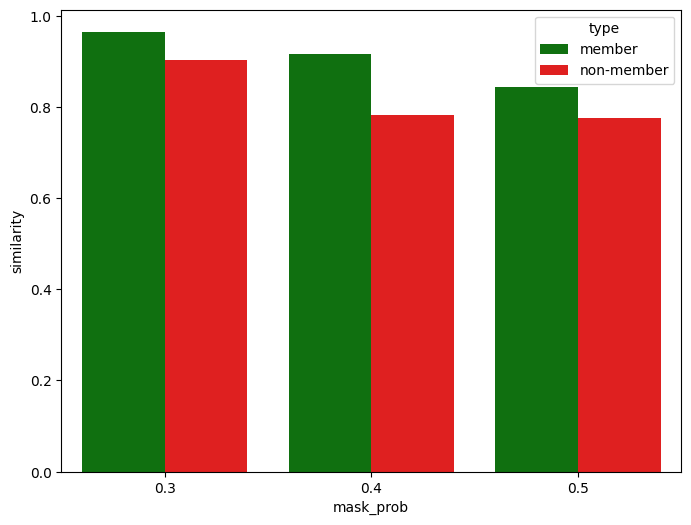

In [17]:
d = news_completions[(news_completions['temperature'] == 0.1)]
plt.figure(figsize=(8, 6))
x = d.groupby(['type', 'mask_prob']).mean('similarity').reset_index()
sns.barplot(x, x='mask_prob', y='similarity', hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.show()

## ROC Curve

In [10]:
df = news_completions.copy()
df['y_true'] = df['type'].map({'member': 1, 'non-member': 0})

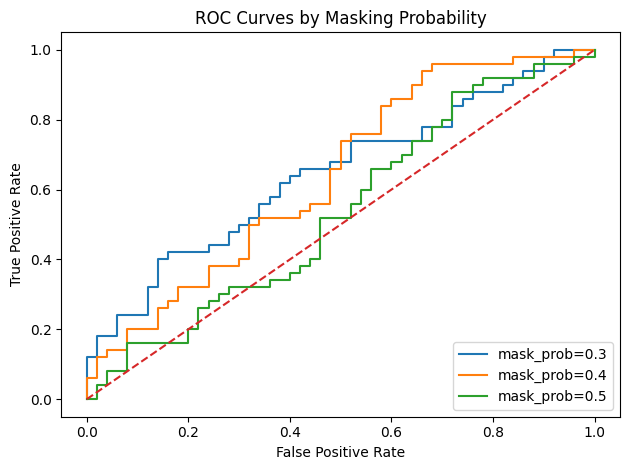

In [13]:
plt.figure()

auc_values = {}

for temp in sorted(df['mask_prob'].unique()):
    sub = df[df['mask_prob'] == temp]
    y_true  = sub['y_true']
    y_score = sub['similarity']
    
    fpr, tpr, _ = roc_curve(y_true, y_score)

    roc_auc = auc(fpr, tpr)
    auc_values[float(temp)] = float(roc_auc)

    
    plt.plot(fpr, tpr, label=f"mask_prob={temp}")

# 4. Format the plot
plt.plot([0, 1], [0, 1], linestyle='--')     # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Masking Probability')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [12]:
auc_values

{0.3: 0.6452000000000001, 0.4: 0.6396000000000001, 0.5: 0.5368}

In [22]:
df = news_completions.copy()
df = df[df['mask_prob'] == 0.3]
df['y_true'] = df['type'].map({'member': 1, 'non-member': 0})

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
j_scores = tpr - fpr
ix = np.argmax(j_scores)
best_thresh = thresholds[ix]

# print(f"Optimal threshold (max J = {j_scores[ix]:.3f}): {best_thresh:.4f}")


y_pred = (y_score >= best_thresh).astype(int)

print(classification_report(
    y_true, 
    y_pred, 
    target_names=['non-member', 'member']
))

              precision    recall  f1-score   support

  non-member       0.70      0.28      0.40        50
      member       0.55      0.88      0.68        50

    accuracy                           0.58       100
   macro avg       0.62      0.58      0.54       100
weighted avg       0.62      0.58      0.54       100

